# Predict Document Classes with Residual Neural Networks

## Install and Import required libraries

In [1]:
from os.path import join, isfile
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import joblib
import seaborn as sns

## Load dataset

In [2]:
data_dir = "../data/kaggle"

trainDir = join(data_dir, "train/train")
validationDir = join(data_dir, "validation/validation")

labels = pd.read_csv(join(data_dir, "train_labels.csv"))
labels.describe()

,id,label
count,16000.000000,16000.000000
mean,7999.500000,7.512437
std,4618.946489,4.601214
min,0.000000,0.000000
25%,3999.750000,4.000000
50%,7999.500000,8.000000
75%,11999.250000,12.000000
max,15999.000000,15.000000


## Convert the images into matrices after compressing them

In [3]:
shape = {
    # chose this ratio as all the images have shape approximately (1000, 750)
    "image": (100, 75)  
    # "image": (300, 225)
}
number_of_tests = 16000
data = np.zeros((number_of_tests, shape["image"][0], shape["image"][1]))

for id in labels['id']:
  data[id] = np.array(Image.open(join(trainDir, str(id) + ".tif")).resize((shape["image"][1], shape["image"][0])), dtype="uint")

In [4]:
X = (data / 255.0).reshape(16000, 100, 75, 1)
Y = np.zeros((16000, 16))
for i, v in enumerate(labels["label"]):
    Y[i][v] = 1
Y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Split into Training and Test Data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print("Train shape: ", X_train.shape, Y_train.shape)
print("Test  shape: ", X_test.shape, Y_test.shape)

Train shape:  (12000, 100, 75, 1) (12000, 16)
Test  shape:  (4000, 100, 75, 1) (4000, 16)


## CNN with 3 cnn layers and 3 dense layers

In [6]:
import tensorflow as tf

# I am using ReLU for all the layers other than the output layer to keep the model linear and fast
# and Softmax for the last layer for classification with 10 nodes as we have 10 classes of the data.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.softmax)
])

# I am using the default learning rate i.e., learning_rate=1e-3
# I am using Adam optimizer as it considers both adaptive learning rate 
# and momentum and is also one the best optimizers empirically
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

model.build(X_train.shape)
model.summary()

2022-12-09 03:14:25.394082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 03:14:25.452042: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-09 03:14:26.254535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-09 03:14:26.254664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (12000, 98, 73, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (12000, 49, 36, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (12000, 47, 34, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (12000, 23, 17, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (12000, 21, 15, 128)      73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (12000, 10, 7, 128)      0

2022-12-09 03:14:27.084989: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-09 03:14:27.085026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (riemann): /proc/driver/nvidia/version does not exist
2022-12-09 03:14:27.085556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
282/282 [==============================] - 23s 79ms/step - loss: 0.2170 - accuracy: 0.1793 - val_loss: 0.1975 - val_accuracy: 0.2983
Epoch 2/10
282/282 [==============================] - 20s 73ms/step - loss: 0.1827 - accuracy: 0.3572 - val_loss: 0.1700 - val_accuracy: 0.4233
Epoch 3/10
282/282 [==============================] - 21s 74ms/step - loss: 0.1550 - accuracy: 0.4739 - val_loss: 0.1512 - val_accuracy: 0.4970
Epoch 4/10
282/282 [==============================] - 22s 77ms/step - loss: 0.1341 - accuracy: 0.5560 - val_loss: 0.1453 - val_accuracy: 0.5303
Epoch 5/10
282/282 [==============================] - 21s 74ms/step - loss: 0.1164 - accuracy: 0.6158 - val_loss: 0.1401 - val_accuracy: 0.5543
Epoch 6/10
282/282 [==============================] - 20s 72ms/step - loss: 0.1022 - accuracy: 0.6649 - val_loss: 0.1395 - val_accuracy: 0.5673
Epoch 7/10
282/282 [==============================] - 22s 78ms/step - loss: 0.0870 - accuracy: 0.7202 - val_loss: 0.1407 - val_accuracy:

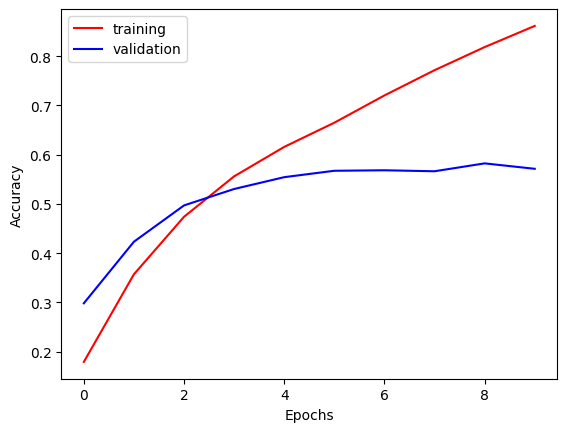

Training Accuracy:  0.8613333106040955
Validation Accuracy:  0.5713333487510681
Test Accuracy:  0.5690000057220459


In [7]:
# Cell to train the CNN model created above and plot the accuracy

history = model.fit(X_train, Y_train, epochs=10, validation_split=0.25)
results = model.evaluate(X_test, Y_test)
plt.plot(history.epoch, history.history["accuracy"], color="r", label="training")
plt.plot(history.epoch, history.history["val_accuracy"], color="b", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# From the plot of training accuracy vs validation accuracy we can see that validation accuracy increases 
# with increase in training accuracy on an average. 
# Hence our model is a good model

print("Training Accuracy: ", history.history["accuracy"][-1])
print("Validation Accuracy: ", history.history["val_accuracy"][-1])
print("Test Accuracy: ", results[1])

## CNN with 2 cnn layers and 3 dense layers

In [8]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.softmax)
])

model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

model1.build(X_train.shape)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (12000, 98, 73, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (12000, 49, 36, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (12000, 47, 34, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (12000, 23, 17, 64)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (12000, 25024)            0         
                                                                 
 dense_3 (Dense)             (12000, 256)             

Epoch 1/10
282/282 [==============================] - 26s 90ms/step - loss: 0.2211 - accuracy: 0.1672 - val_loss: 0.1966 - val_accuracy: 0.3230
Epoch 2/10
282/282 [==============================] - 23s 83ms/step - loss: 0.1719 - accuracy: 0.4063 - val_loss: 0.1644 - val_accuracy: 0.4417
Epoch 3/10
282/282 [==============================] - 24s 84ms/step - loss: 0.1362 - accuracy: 0.5452 - val_loss: 0.1506 - val_accuracy: 0.5043
Epoch 4/10
282/282 [==============================] - 24s 84ms/step - loss: 0.1074 - accuracy: 0.6467 - val_loss: 0.1485 - val_accuracy: 0.5283
Epoch 5/10
282/282 [==============================] - 23s 82ms/step - loss: 0.0810 - accuracy: 0.7390 - val_loss: 0.1522 - val_accuracy: 0.5543
Epoch 6/10
282/282 [==============================] - 25s 87ms/step - loss: 0.0554 - accuracy: 0.8307 - val_loss: 0.1782 - val_accuracy: 0.5440
Epoch 7/10
282/282 [==============================] - 22s 80ms/step - loss: 0.0352 - accuracy: 0.8992 - val_loss: 0.1899 - val_accuracy:

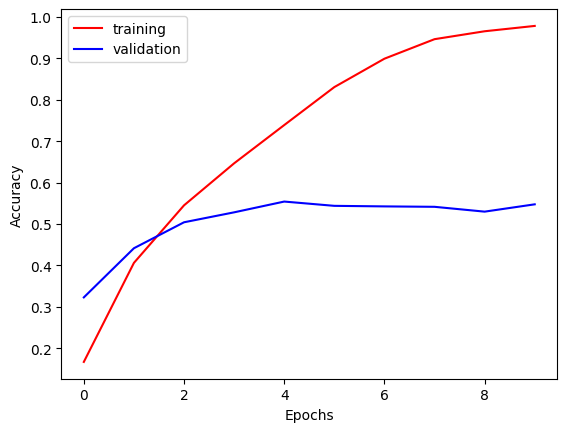

Training Accuracy:  0.9783333539962769
Validation Accuracy:  0.5476666688919067
Test Accuracy:  0.5460000038146973


In [9]:
# Cell to train the CNN model created above and plot the accuracy

history1 = model1.fit(X_train, Y_train, epochs=10, validation_split=0.25)
results1 = model1.evaluate(X_test, Y_test)
plt.plot(history1.epoch, history1.history["accuracy"], color="r", label="training")
plt.plot(history1.epoch, history1.history["val_accuracy"], color="b", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# From the plot of training accuracy vs validation accuracy we can see that validation accuracy increases 
# with increase in training accuracy on an average. 
# Hence our model is a good model

print("Training Accuracy: ", history1.history["accuracy"][-1])
print("Validation Accuracy: ", history1.history["val_accuracy"][-1])
print("Test Accuracy: ", results1[1])

## CNN with 3 cnn layers and 2 dense layers

In [10]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),    
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.softmax)
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

model2.build(X_train.shape)
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (12000, 98, 73, 32)       320       
                                                                 
 max_pooling2d_5 (MaxPooling  (12000, 49, 36, 32)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (12000, 47, 34, 64)       18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (12000, 23, 17, 64)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (12000, 21, 15, 128)      73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (12000, 10, 7, 128)     

Epoch 1/10
282/282 [==============================] - 23s 79ms/step - loss: 0.2158 - accuracy: 0.1867 - val_loss: 0.1917 - val_accuracy: 0.3333
Epoch 2/10
282/282 [==============================] - 21s 73ms/step - loss: 0.1731 - accuracy: 0.4118 - val_loss: 0.1639 - val_accuracy: 0.4470
Epoch 3/10
282/282 [==============================] - 22s 79ms/step - loss: 0.1437 - accuracy: 0.5246 - val_loss: 0.1486 - val_accuracy: 0.5123
Epoch 4/10
282/282 [==============================] - 22s 76ms/step - loss: 0.1252 - accuracy: 0.5919 - val_loss: 0.1477 - val_accuracy: 0.5363
Epoch 5/10
282/282 [==============================] - 19s 69ms/step - loss: 0.1075 - accuracy: 0.6490 - val_loss: 0.1458 - val_accuracy: 0.5520
Epoch 6/10
282/282 [==============================] - 22s 77ms/step - loss: 0.0918 - accuracy: 0.7014 - val_loss: 0.1512 - val_accuracy: 0.5500
Epoch 7/10
282/282 [==============================] - 20s 73ms/step - loss: 0.0759 - accuracy: 0.7609 - val_loss: 0.1596 - val_accuracy:

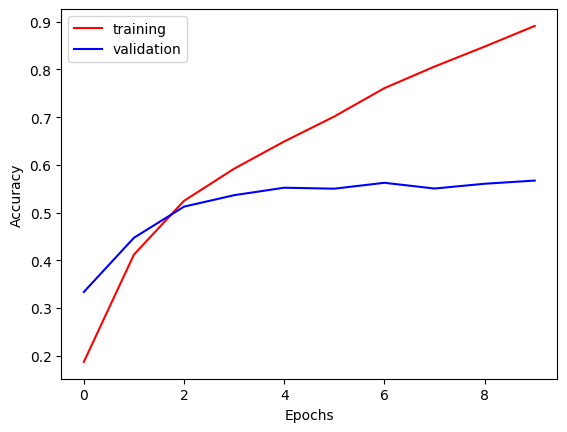

Training Accuracy:  0.8913333415985107
Validation Accuracy:  0.5669999718666077
Test Accuracy:  0.5820000171661377


In [11]:
# Cell to train the CNN model created above and plot the accuracy

history2 = model2.fit(X_train, Y_train, epochs=10, validation_split=0.25)
results2 = model2.evaluate(X_test, Y_test)
plt.plot(history2.epoch, history2.history["accuracy"], color="r", label="training")
plt.plot(history2.epoch, history2.history["val_accuracy"], color="b", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# From the plot of training accuracy vs validation accuracy we can see that validation accuracy increases 
# with increase in training accuracy on an average. 
# Hence our model is a good model

print("Training Accuracy: ", history2.history["accuracy"][-1])
print("Validation Accuracy: ", history2.history["val_accuracy"][-1])
print("Test Accuracy: ", results2[1])

## Best model metrics visualizatoin

In [15]:
from sklearn.metrics import accuracy_score, classification_report

best_model = model
best_result = results
if results1[1] > results[1]:
    best_model = model1
    best_result = results1
if results2[1] > results[1]:
    best_model = model2
    best_result = results2

Y_pred = model.predict(X_test)
test_prediction = []
for i in range(len(Y_pred)):
    id = np.argmax(Y_pred[i])
    test_prediction.append(id)
    
test_actual = []
for i in range(len(Y_test)):
    id = np.argmax(Y_test[i])
    test_actual.append(id)
    
test_actual = np.array(test_actual)
test_prediction = np.array(test_prediction)
accuracy = accuracy_score(test_actual,test_prediction)
print("Best Accuracy with CNN: ", accuracy)
print(classification_report(test_actual,test_prediction))

125/125 [==============================] - 3s 20ms/step
Best Accuracy with CNN:  0.569
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       248
           1       0.44      0.26      0.33       252
           2       0.84      0.81      0.83       225
           3       0.78      0.55      0.64       232
           4       0.65      0.68      0.66       247
           5       0.37      0.33      0.35       238
           6       0.57      0.74      0.64       258
           7       0.53      0.67      0.59       269
           8       0.83      0.75      0.79       277
           9       0.48      0.65      0.55       247
          10       0.51      0.50      0.51       240
          11       0.40      0.50      0.45       248
          12       0.56      0.39      0.46       242
          13       0.37      0.46      0.41       267
          14       0.76      0.75      0.75       264
          15       0.61      0.51      0.56     

In [16]:
classes = list(range(16))
res = tf.math.confusion_matrix(test_prediction,test_actual).numpy()
cm = pd.DataFrame(res,
                     index = classes, 
                     columns = classes)

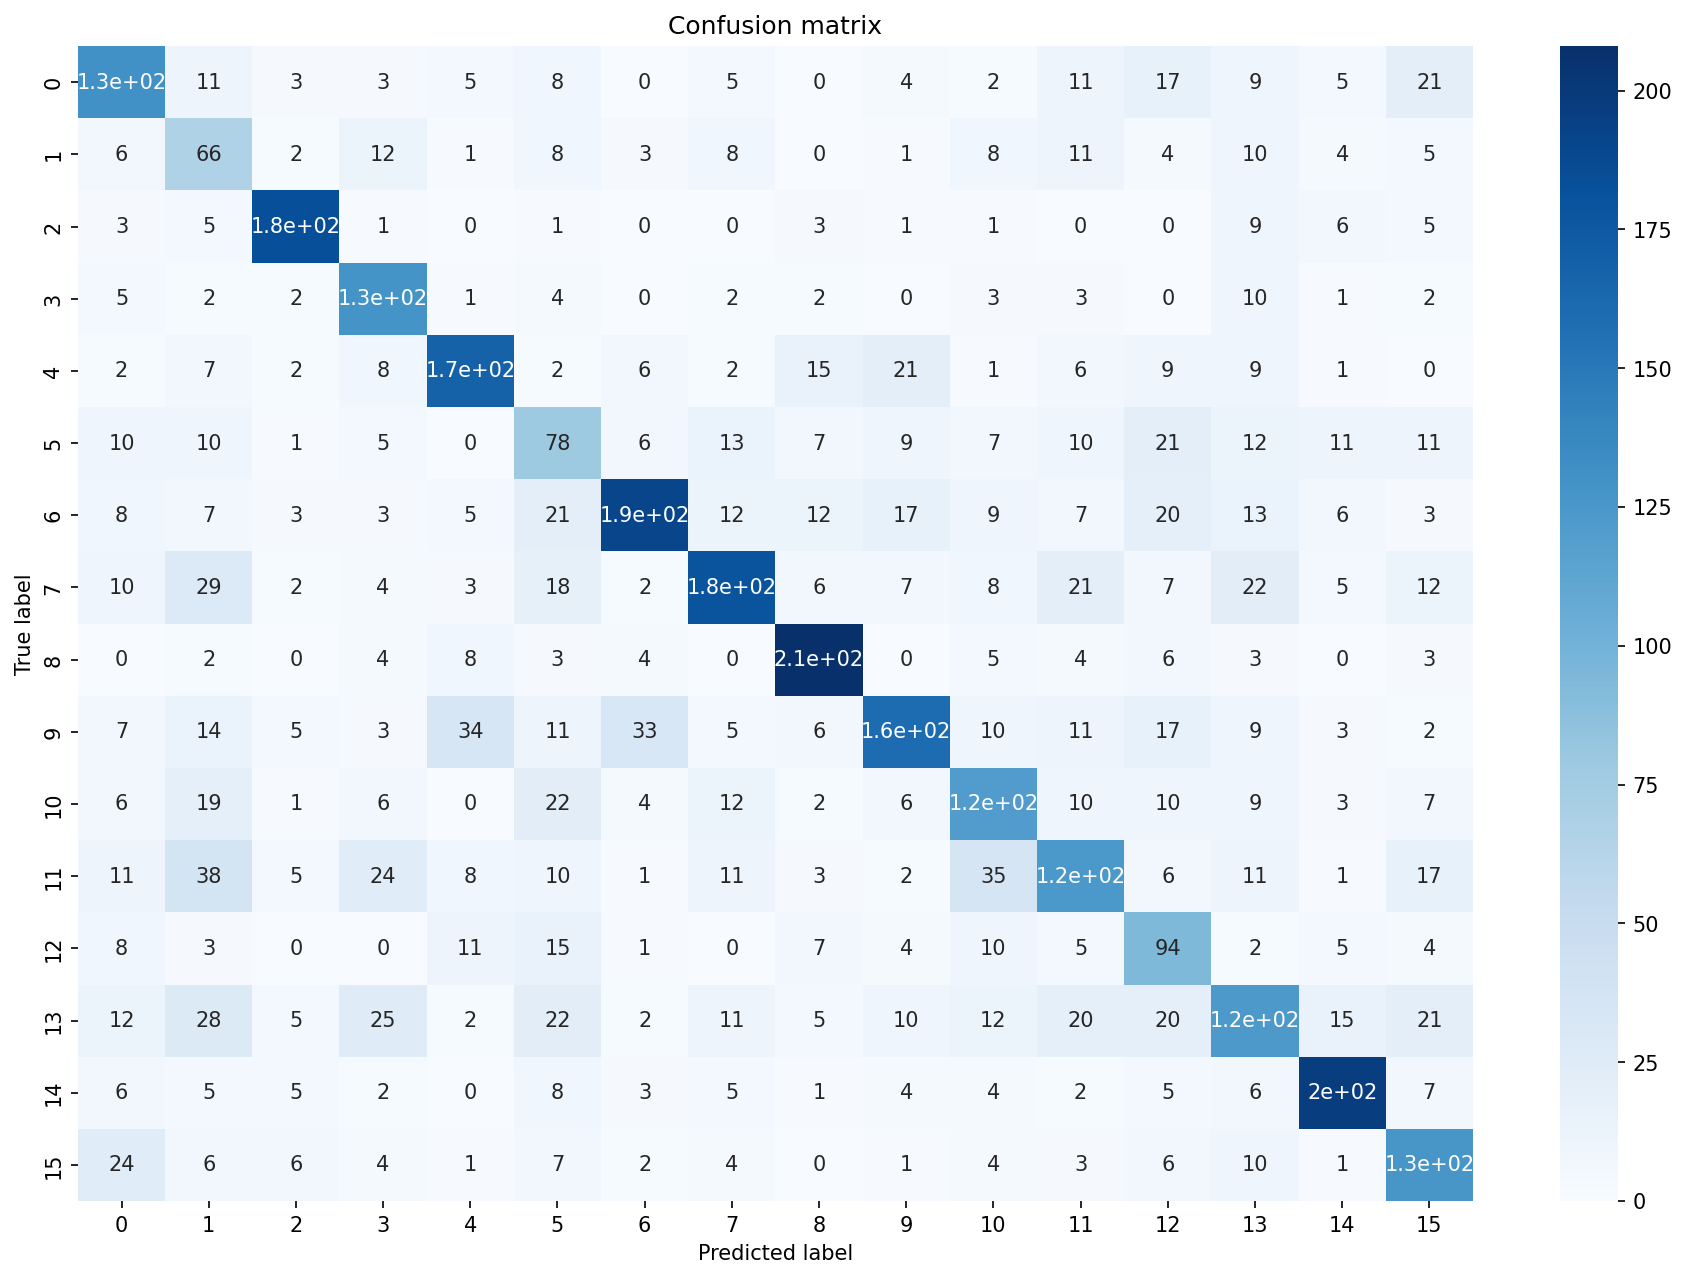

In [17]:
import seaborn as sns
figure = plt.figure(figsize=(15, 10), dpi=150)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix')
plt.show()